# <font color=#1F765C><center>Starbucks Capstone Challenge</center></font>

<img src="images/logo.jpg"/>

# 1. Project Description

### 1.1 Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### 1.2 Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### 1.3 Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### 1.4 Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# 2. Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="images/pic1.png"/>

Then you will want to run the above command:

<img src="images/pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [83]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 3. Exploratory Data Analysis

## 3.1 Exploring profile.json File

##### - View top 5 rows

In [84]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


##### - Dimension of data

In [85]:
profile.shape

(17000, 5)

##### - Columns having null values

In [86]:
null_cols = profile.isnull().sum() > 0
null_cols

age                 False
became_member_on    False
gender               True
id                  False
income               True
dtype: bool

##### - Draw the boxplot of age

{'whiskers': [<matplotlib.lines.Line2D at 0x11a3dffd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1207c6a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1207c6b70>],
 'medians': [<matplotlib.lines.Line2D at 0x1207c6cf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1207cb080>],
 'means': []}

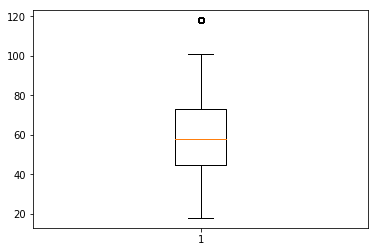

In [87]:
plt.boxplot(profile['age'])

##### - Find how many null values are there in gender column

In [88]:
gender_null_count = profile['gender'].isnull().sum()
gender_null_count

2175

##### - Find how many null values are there in income column

In [89]:
income_null_count = profile['income'].isnull().sum()
income_null_count

2175

##### - Get the gender and income of customers whose age is greater than 100.

In [90]:
outliers_data = profile[profile['age']>100]
outliers_data['age'].value_counts()

118    2175
101       5
Name: age, dtype: int64

##### - Are these 2175 people same whose gender and income is unknown

In [91]:
outliers_data[outliers_data['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [92]:
a = outliers_data[outliers_data['age']==118]['income'].isnull().sum()
a

2175

In [93]:
b = outliers_data[outliers_data['age']==118]['gender'].isnull().sum()
b

2175

<font color="red"> Yes, they are same. </font>

##### - Can you find the proportion of outlier in dataset?

In [94]:
prop = 2175/17000
prop

0.12794117647058822

In [95]:
new_profile = profile[(profile['age']<118) & (~profile['gender'].isnull()) & (~profile['income'].isnull())]
new_profile.head(5)

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


##### - Again draw the boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x1207e9eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x1207ee6d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1207e9f60>],
 'medians': [<matplotlib.lines.Line2D at 0x1207eeb00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1207f16d8>],
 'means': []}

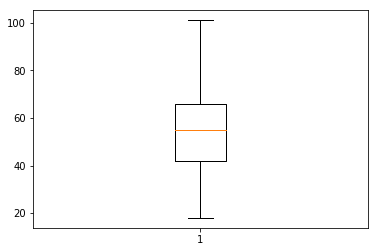

In [96]:
plt.boxplot(new_profile['age'])

##### - Visualize gender data

<BarContainer object of 3 artists>

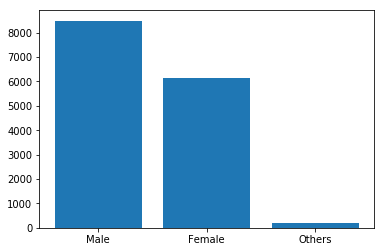

In [97]:
gender_count = list(new_profile['gender'].value_counts())
labels = ['Male', 'Female', 'Others']
plt.bar(labels, gender_count)

##### - Find the median income of people who visit startbucks

In [98]:
avg_income = np.median(new_profile['income'])
avg_income

64000.0

##### - Find the ratio of gender who visit Starbucks and earns more than or equals to average income

In [99]:
income_count = new_profile[new_profile['income']>=68000]['gender'].value_counts()
income_count

F    3394
M    2999
O      86
Name: gender, dtype: int64

<BarContainer object of 3 artists>

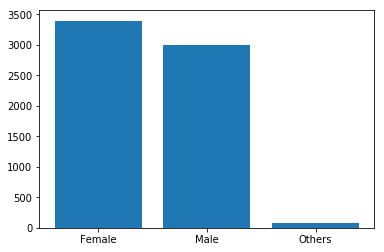

In [100]:
plt.bar(['Female','Male','Others'],list(income_count))

##### - Can we identify the age range of people who earn more than median income?

In [101]:
income_range = new_profile[new_profile['income']>=68000]
in

SyntaxError: invalid syntax (<ipython-input-101-dc98b01078bf>, line 2)

{'whiskers': [<matplotlib.lines.Line2D at 0x120853fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x120856358>,
 'boxes': [<matplotlib.lines.Line2D at 0x120853860>],
 'medians': [<matplotlib.lines.Line2D at 0x120856d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x120856e10>],
 'means': []}

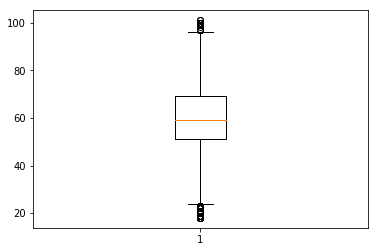

In [102]:
plt.boxplot(income_range['age'])

In [121]:
outliers_profileID  = profile[profile['age']==118]['id']
outliers_profileID.head(5)

0    68be06ca386d4c31939f3a4f0e3dd783
2    38fe809add3b4fcf9315a9694bb96ff5
4    a03223e636434f42ac4c3df47e8bac43
6    8ec6ce2a7e7949b1bf142def7d0e0586
7    68617ca6246f4fbc85e91a2a49552598
Name: id, dtype: object

## 3.2 Exploring portfolio.json File

In [128]:
portfolio.shape

(10, 6)

In [129]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [126]:
portfolio['offer_type'].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

## 3.3 Exploring transcript.json File

In [125]:
transcript[transcript['person']=='9b84c5f2038e4f638813091d3565a8f0']

,event,person,time,value
12026,offer received,9b84c5f2038e4f638813091d3565a8f0,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
24117,offer viewed,9b84c5f2038e4f638813091d3565a8f0,24,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
24118,transaction,9b84c5f2038e4f638813091d3565a8f0,24,{'amount': 0.43}
26028,transaction,9b84c5f2038e4f638813091d3565a8f0,30,{'amount': 2.91}
51308,transaction,9b84c5f2038e4f638813091d3565a8f0,150,{'amount': 2.5}
65239,offer received,9b84c5f2038e4f638813091d3565a8f0,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
69171,transaction,9b84c5f2038e4f638813091d3565a8f0,168,{'amount': 0.89}
72027,offer viewed,9b84c5f2038e4f638813091d3565a8f0,174,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
72028,transaction,9b84c5f2038e4f638813091d3565a8f0,174,{'amount': 0.86}
83310,transaction,9b84c5f2038e4f638813091d3565a8f0,204,{'amount': 2.07}
